In [1]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [2]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [4]:
# with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/valid.jsonl", "r") as f:
#     comment_dataset = [json.loads(line) for line in f.readlines()]

# with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/codebase.jsonl", "r") as f:
#     code_dataset = [json.loads(line) for line in f.readlines()]

In [5]:
data_ind = 0
convert_idx = 11637
convert_idx_code = 18268

In [6]:
# for i in range(1, 21):
#     source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/valid_nl_tokens_curr.npy'
#     destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/nl_tokens_{i}.npy'
#     shutil.copyfile(source_file, destination_file)
# for i in range(1, 21):
#     source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/valid_code_tokens_curr.npy'
#     destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/code_tokens_{i}.npy'
#     shutil.copyfile(source_file, destination_file)
    
    

In [7]:
# for i in range(1, 21):
#     source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/valid_nl_attention_curr.npy'
#     destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/nl_attention_{i}.npy'
#     shutil.copyfile(source_file, destination_file)
# for i in range(1, 21):
#     source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/valid_code_attention_curr.npy'
#     destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/code_attention_{i}.npy'
#     shutil.copyfile(source_file, destination_file)

In [8]:
import numpy as np

# 文件路径
nl_tokens_paths = [f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/nl_tokens_{i}.npy' for i in range(1,21)]
code_tokens_paths = [f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/code_tokens_{i}.npy' for i in range(1,21)]

# 读取nl_tokens.npy
all_nl_tokens_list = []
for path in nl_tokens_paths:
    all_nl_tokens_list.append(np.load(path))

# 读取code_tokens.npy 
all_code_tokens_list = []
for path in code_tokens_paths:
    all_code_tokens_list.append(np.load(path))

In [9]:
# 文件路径
code_attention_paths = [f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/code_attention_{i}.npy' for i in range(1,21)]
nl_attention_paths = [f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/features/nl_attention_{i}.npy' for i in range(1,21)]

# 读取code attention features
code_attention_features = []
for path in code_attention_paths:
    code_attention_features.append(np.load(path))

# 读取nl attention features
nl_attention_features = []
for path in nl_attention_paths:
    nl_attention_features.append(np.load(path))

In [11]:
import numpy as np
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

# 初始化存储所有epoch数据的列表
all_intra_comment_sims = []
all_intra_code_sims = []
all_inter_comment_code_sims = []
all_inter_code_comment_sims = []

# 读取 comment token 长度
data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/comment_index.json'
with open(data_index_path, 'r') as f:
    comment_length = len(json.load(f))

data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/code_index.json'
with open(data_index_path, 'r') as f:
    code_length = len(json.load(f))

# 对每个epoch进行处理
for epoch in range(1, 21):
    # 读取数据
    data_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/visualize/DVI/projection/train_data_{epoch}.npy'
    data = np.load(data_path)

    # 将数据分为前半部分的comment和后半部分的code
    comments = data[:comment_length]  # 前半部分是comment
    code_tokens = data[comment_length:]  # 后半部分是code

    # 计算相似度函数（使用余弦相似度）
    def compute_similarity(tokens_a, tokens_b):
        return cosine_similarity(tokens_a, tokens_b)

    # intra 相似度计算
    intra_comment_sim = compute_similarity(comments, comments)
    intra_code_sim = compute_similarity(code_tokens, code_tokens)

    # inter 相似度计算
    inter_comment_code_sim = compute_similarity(comments, code_tokens)
    inter_code_comment_sim = compute_similarity(code_tokens, comments)

    # 获取前 k 个最近邻
    k = 10  # 假设我们需要前 5 个最近邻

    # intra 计算
    def get_intra_neighbors(sim_matrix, k, offset=0):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前样本对其他样本的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果样本数量不足k个，用自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices + offset,
                    np.array([i + offset] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k] + offset)
        return np.array(neighbors)

    intra_comment_neighbors = get_intra_neighbors(intra_comment_sim, k)
    intra_code_neighbors = get_intra_neighbors(intra_code_sim, k, comment_length)

    # inter 计算 - 应该使用专门的函数处理comment到code的映射
    def get_comment_to_code_neighbors(sim_matrix, k, code_offset):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前注释对所有代码的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 将代码的索引加上offset以对应实际位置
            neighbors.append(sorted_indices[:k] + code_offset)
        return np.array(neighbors)

    inter_comment_neighbors = get_comment_to_code_neighbors(inter_comment_code_sim, k, comment_length)  # comment 对 code 的相似度
    
    def get_code_to_comment_neighbors(sim_matrix, k, comment_length):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前代码对所有注释的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果注释数量不足k个，用代码自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices,
                    np.array([i + comment_length] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k])
        return np.array(neighbors)

    inter_code_neighbors = get_code_to_comment_neighbors(inter_code_comment_sim, k, comment_length)

    # 拼接 intra 和 inter 结果
    intra_neighbors = np.concatenate([intra_comment_neighbors, intra_code_neighbors], axis=0)
    inter_neighbors = np.concatenate([inter_comment_neighbors, inter_code_neighbors], axis=0)

    # 将当前epoch的结果添加到列表中
    all_intra_comment_sims.append(intra_comment_sim)
    all_intra_code_sims.append(intra_code_sim)
    all_inter_comment_code_sims.append(inter_comment_code_sim)
    all_inter_code_comment_sims.append(inter_code_comment_sim)

    # 保存每个epoch的邻居信息
    intra_save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/intra_similarity'
    inter_save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/dataset/inter_similarity'


    # 保存邻居信息
    np.save(os.path.join(intra_save_dir, f'{epoch}.npy'), intra_neighbors)
    np.save(os.path.join(inter_save_dir, f'{epoch}.npy'), inter_neighbors)



In [12]:
# 预设10种高对比度颜色
high_contrast_colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFA500", "#FF00FF", 
    "#00FFFF", "#800000", "#008000", "#000080", "#808000"
]

In [13]:
import numpy as np
from sklearn.cluster import DBSCAN

selected_epoch = 19

# 读取 comment token 长度
data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/comment_index.json'
with open(data_index_path, 'r') as f:
    comment_length = len(json.load(f))

data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/code_index.json'
with open(data_index_path, 'r') as f:
    code_length = len(json.load(f))

# Load train data for the selected epoch
output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/visualize/DVI/projection'
train_data_path = os.path.join(output_dir, f'train_data_{selected_epoch}.npy')
train_data = np.load(train_data_path)

# Split train data based on comment length and code length
comment_vectors = train_data[:comment_length]
code_vectors = train_data[comment_length:]

# 设置相似度阈值
similarity_threshold = 0.7  # 用于判断相似性

# 加载代码和注释的注意力数据
code_attention = code_attention_features[selected_epoch-1][data_ind][1:code_length]
comment_attention = nl_attention_features[selected_epoch-1][data_ind][1:comment_length]

# 计算代码和注释的平均注意力
avg_code_attention = np.mean(code_attention)
avg_comment_attention = np.mean(comment_attention)

# 筛选高于平均注意力的索引
filtered_code_indices = np.where(code_attention > avg_code_attention)[0]
filtered_comment_indices = np.where(comment_attention > avg_comment_attention)[0]

# 提取对应的代码和注释向量
filtered_code_vectors = code_vectors[1:][filtered_code_indices]
filtered_comment_vectors = comment_vectors[1:][filtered_comment_indices]

# 合并代码和注释向量作为聚类数据
combined_vectors = np.vstack((filtered_code_vectors, filtered_comment_vectors))
print(combined_vectors.shape)

# 计算余弦相似度矩阵
similarity_matrix = cosine_similarity(combined_vectors)

# 将相似度转换为距离（确保相似度不超出范围）
distance_matrix = 1 - similarity_matrix

# 将所有负值截断为 0，避免数值误差导致问题
distance_matrix = np.clip(distance_matrix, 0, None)

clustering = DBSCAN(eps=1-similarity_threshold, min_samples=1, metric='precomputed').fit(distance_matrix)

# 获取聚类标签
cluster_labels = clustering.labels_

# 记录索引的映射（用于恢复原始索引）
original_indices = np.concatenate((filtered_code_indices, filtered_comment_indices + code_length))

# 存储聚类结果
clusters = {}
for idx, label in enumerate(cluster_labels):
    if label == -1:
        continue  # 跳过噪声点
    if label not in clusters:
        clusters[label] = {'code_indices': set(), 'comment_indices': set()}
    
    original_idx = original_indices[idx]
    if original_idx < code_length:
        clusters[label]['code_indices'].add(original_idx)
    else:
        clusters[label]['comment_indices'].add(original_idx - code_length)

# 按群组大小排序
sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]['code_indices']) + len(x[1]['comment_indices']), reverse=True)

# 打印结果
print(f"发现 {len(sorted_clusters)} 个聚类群组")
for group_idx, (label, group) in enumerate(sorted_clusters):
    print(f"\n群组 {group_idx + 1} (大小: {len(group['code_indices']) + len(group['comment_indices'])}):")
    print(f"  代码 token 索引: {sorted(list(group['code_indices']))}")
    print(f"  注释 token 索引: {sorted(list(group['comment_indices']))}")


(21, 768)
发现 6 个聚类群组

群组 1 (大小: 8):
  代码 token 索引: [0, 1, 12, 13, 14, 15, 16, 17]
  注释 token 索引: []

群组 2 (大小: 5):
  代码 token 索引: [21, 41, 42]
  注释 token 索引: [2, 3]

群组 3 (大小: 4):
  代码 token 索引: [5, 19, 44]
  注释 token 索引: [6]

群组 4 (大小: 2):
  代码 token 索引: [10]
  注释 token 索引: [7]

群组 5 (大小: 1):
  代码 token 索引: [3]
  注释 token 索引: []

群组 6 (大小: 1):
  代码 token 索引: [8]
  注释 token 索引: []


In [20]:
import json

# Load data from full_text.json
with open('/home/yiming/cophi/training_dynamic/gcb_tokens_visactor/full_text.json', 'r', encoding='utf-8') as f:
    data_dict = json.load(f)

# Extract code tokens data and nl tokens data
code_tokens_data = data_dict['code_tokens']
nl_tokens_data = data_dict['comment_tokens']
doc_snippet = data_dict['comment_text']
code_snippet = data_dict['code_text']



In [21]:
import numpy as np
from IPython.display import display, HTML
from collections import deque

# Process code part
code_snippet = remove_docstrings(code_snippet)
token_list2 = code_tokens_data[1:]
token_list1 = nl_tokens_data[1:]

# Get docstring and remove parameter descriptions
doc_snippet = doc_snippet.split("\n")[0]

# Remove any parts of code_snippet that appear in doc_snippet
doc_words = set(doc_snippet.lower().split())
code_lines = code_snippet.split('\n')
filtered_code_lines = []

for line in code_lines:
    # Skip line if it contains too many words from docstring
    line_words = set(line.lower().split())
    overlap = len(line_words.intersection(doc_words))
    if overlap < len(line_words) / 2:  # Keep line if less than 50% overlap
        filtered_code_lines.append(line)

code_snippet = '\n'.join(filtered_code_lines)

# Process comment part - using the similarity groups we defined earlier
array = nl_attention_features[selected_epoch-1][data_ind]  # Get data for current epoch
array = array[1:]

normalized_contributions = (array - array.min()) / (array.max() - array.min())
tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list1, normalized_contributions)])

code_attention_feature = code_attention_features[selected_epoch-1][data_ind][1:]
code_normalized_contributions = (code_attention_feature - code_attention_feature.min()) / (code_attention_feature.max() - code_attention_feature.min())
code_tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list2, code_normalized_contributions)])

# Use the similarity groups to assign colors
# Each group contains {'codes': set(), 'comments': set()}
color_map_comment = {}
color_map_code = {}

for group_idx, (label, group) in enumerate(sorted_clusters):
    color = high_contrast_colors[group_idx % len(high_contrast_colors)]
    for code_idx in group['code_indices']:
        color_map_code[code_idx] = color
    for comment_idx in group['comment_indices']:
        color_map_comment[comment_idx] = color

# Generate HTML output
html_string = "<h4 style='margin:0'>Comment:</h4><pre>"
buffer = ""
current_index = 0
for char in doc_snippet:
    if char == "\n":
        html_string += buffer + "<br>"
        buffer = ""
    elif tokens_with_contributions:
        token, contrib = tokens_with_contributions[0]
        buffer += char
        if buffer == token:
            font_size = 8 + (16 - 8) * contrib
            color = color_map_comment.get(current_index, "black")
            html_string += f'<span style="font-size: {font_size}px; color: {color};">{buffer}</span>'
            buffer = ""
            tokens_with_contributions.popleft()
            current_index += 1
        elif not token.startswith(buffer):
            color = color_map_comment.get(current_index, "black")
            html_string += f'<span style="color: {color};">{buffer[0]}</span>'
            buffer = buffer[1:]
    else:
        color = color_map_comment.get(current_index, "black")
        html_string += f'<span style="color: {color};">{char}</span>'
html_string += buffer + "</pre>"

# Code part
html_string += "<h4 style='margin:0'>Code:</h4><pre>"
buffer = ""
current_index = 0
for char in code_snippet:
    if char == "\n":
        html_string += buffer + "<br>"
        buffer = ""
    elif code_tokens_with_contributions:
        token, contrib = code_tokens_with_contributions[0]
        buffer += char
        if buffer == token:
            font_size = 8 + (16 - 8) * contrib
            color = color_map_code.get(current_index, "black")
            html_string += f'<span style="font-size: {font_size}px; color: {color};">{buffer}</span>'
            buffer = ""
            code_tokens_with_contributions.popleft()
            current_index += 1
        elif not token.startswith(buffer):
            color = color_map_code.get(current_index, "black")
            html_string += f'<span style="color: {color};">{buffer[0]}</span>'
            buffer = buffer[1:]
    else:
        color = color_map_code.get(current_index, "black")
        html_string += f'<span style="color: {color};">{char}</span>'
html_string += buffer + "</pre>"

# Display result
display(HTML(html_string))

Attention sums by color group:

Comment:
   #00FF00: 0.2553
   #0000FF: 0.1555
   #FFA500: 0.2090

Code:
   #FF0000: 0.2732
   #00FF00: 0.1039
   #0000FF: 0.2935
   #FFA500: 0.0303
   #FF00FF: 0.0815
   #00FFFF: 0.0236


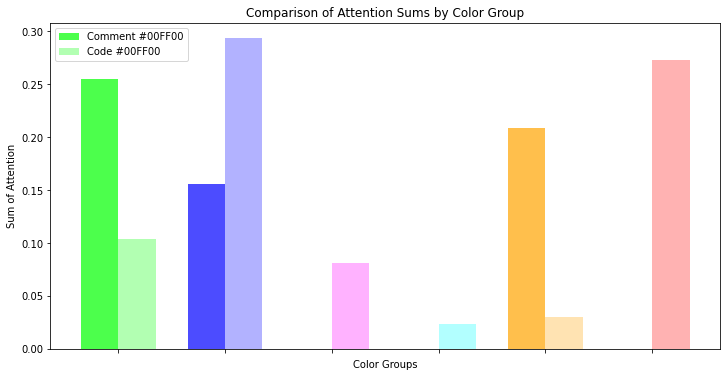

In [19]:
import matplotlib.pyplot as plt
# Calculate sum of attention by color groups
color_groups_comment = {}
color_groups_code = {}

# Group attentions by color for comments
for idx, color in color_map_comment.items():
    if color not in color_groups_comment:
        color_groups_comment[color] = []
    color_groups_comment[color].append(array[idx])

# Group attentions by color for code
for idx, color in color_map_code.items():
    if color not in color_groups_code:
        color_groups_code[color] = []
    color_groups_code[color].append(code_attention_feature[idx])

# Calculate sums for each color group
comment_color_sums = {color: np.sum(attns) for color, attns in color_groups_comment.items()}
code_color_sums = {color: np.sum(attns) for color, attns in color_groups_code.items()}

# Print comparison with color blocks
print("Attention sums by color group:")
print("\nComment:")
for color, sum_val in comment_color_sums.items():
    print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")
    
print("\nCode:")
for color, sum_val in code_color_sums.items():
    print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")

# Plot comparison
plt.figure(figsize=(12,6))

colors = list(set(color_map_comment.values()) | set(color_map_code.values()))
x = np.arange(len(colors))
width = 0.35

comment_sums = [comment_color_sums.get(c, 0) for c in colors]
code_sums = [code_color_sums.get(c, 0) for c in colors]

# Use the same colors for both comment and code bars
for i, (c_sum, cd_sum, color) in enumerate(zip(comment_sums, code_sums, colors)):
    plt.bar(i - width/2, c_sum, width, color=color, alpha=0.7, label=f'Comment {color}' if i==0 else "")
    plt.bar(i + width/2, cd_sum, width, color=color, alpha=0.3, label=f'Code {color}' if i==0 else "")

plt.xlabel('Color Groups')
plt.ylabel('Sum of Attention')
plt.title('Comparison of Attention Sums by Color Group')

# Create colored rectangles for x-axis labels
ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels([''] * len(colors))  # Clear text labels
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i-0.2, -0.1), 0.4, 0.05, color=color, transform=ax.transData))

plt.legend()
plt.show()
